In [1]:
import requests
import os
import pandas as pd
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

load_dotenv()

url = "https://americas.api.riotgames.com/"
token = os.getenv("API_TOKEN")
# Set the API key in the header
headers = {
    "X-Riot-Token": token
}


In [2]:
def get_summonner_id(name, tag):
    # If the name or tag has a space, replace it with %20
    name = name.replace(" ", "%20")

    summonner_url = url + "riot/account/v1/accounts/by-riot-id/" + name + "/" + tag
    response = requests.get(summonner_url, headers=headers)
    return response.json()['puuid']

In [3]:
def get_summonner_matches(summonner_id):
    match_url = url + "lol/match/v5/matches/by-puuid/" + summonner_id + "/ids?start=0&count=10"
    response = requests.get(match_url, headers=headers)
    return response.json()

In [4]:
summonner = get_summonner_id("Mad Freestyle", "BR1")
matches = get_summonner_matches(summonner)

In [5]:
def get_match_info(match_id):
    match_url = url + "lol/match/v5/matches/" + match_id + '?includeTimeline=true'
    response = requests.get(match_url, headers=headers)
    return response.json()

In [6]:
def get_match_individual_stats(info, summonner_id):
    summonner_info = list(filter(lambda x: x['puuid'] == summonner_id, info['info']['participants']))[0]
    enemy = list(filter(lambda x: x['individualPosition'] == summonner_info['individualPosition'] and x['puuid'] != summonner_id, info['info']['participants']))[0]
    return {
        "lane": summonner_info['individualPosition'],
        "kda": summonner_info['challenges']['kda'],
        "championName": summonner_info['championName'],
        "championId": summonner_info['championId'],
        "kills": summonner_info['kills'],
        "deaths": summonner_info['deaths'],
        "assists": summonner_info['assists'],
        "enemyChampionName": enemy['championName'],
        "enemyChampionId": enemy['championId'],
    }

In [13]:
def get_champion_photo(champion_id):
    champion_id = str(champion_id)
    champion_url = "https://raw.communitydragon.org/latest/plugins/rcp-be-lol-game-data/global/default/v1/champion-icons/" + champion_id + ".png"
    return champion_url

In [8]:
def get_match_timeline(match_id):
    match_url = url + "lol/match/v5/matches/" + match_id + '/timeline'
    response = requests.get(match_url, headers=headers)
    return response.json()

In [9]:
match_info = get_match_timeline(matches[8])

In [10]:
def discover_player_in_timeline(match_timeline):
    players = match_timeline['info']['participants']
    for player in players:
        if player['puuid'] == summonner:
            return player

In [11]:
def get_all_coordinates(player, match_timeline):
    frames = match_timeline['info']['frames']
    coordinates = []
    for frame in frames:
        for event in frame['events']:
            if event['type'] == "CHAMPION_KILL" and event['killerId'] == player['participantId']:
                coordinates.append((event['position']['x'], event['position']['y'], 'kill'))
            elif event['type'] == "CHAMPION_KILL" and 'assistingParticipantIds' in event and player['participantId'] in event['assistingParticipantIds']:
                coordinates.append((event['position']['x'], event['position']['y'], 'assist'))
    return coordinates

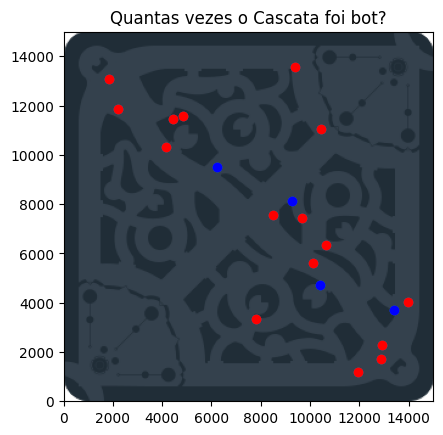

In [12]:
# Plot a graphic with the all coordinates of the summonner
player = discover_player_in_timeline(match_info)
coordinates = get_all_coordinates(player, match_info)
df = pd.DataFrame(coordinates, columns=['x', 'y', 'type'])

# On plot, define max x and max y to 16000
plt.xlim(0, 15000)
plt.ylim(0, 15000)

# Insert the image of the map
img = Image.open("map.png")
plt.imshow(img, extent=[0, 15000, 0, 15000])

plt.scatter(df['x'], df['y'])

# If kill, the coordinate is red, if assist, the coordinate is blue
for i in range(len(df)):
    if df['type'][i] == 'kill':
        plt.scatter(df['x'][i], df['y'][i], color='red')
    else:
        plt.scatter(df['x'][i], df['y'][i], color='blue')

plt.title("Quantas vezes o Cascata foi bot?")
plt.show()